# Проект: Прогнозирование оттока клиентов

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Ваша задача — обучить на этих данных модель для прогноза оттока клиентов.

## 📄 Описание данных

Данные состоят из нескольких файлов, полученных из разных источников:

- **`contract_new.csv`** — информация о договоре  
- **`personal_new.csv`** — персональные данные клиента  
- **`internet_new.csv`** — информация об интернет-услугах  
- **`phone_new.csv`** — информация об услугах телефонии  

---

### 📁 Файл `contract_new.csv`

> **customerID** — идентификатор абонента  
> **BeginDate** — дата начала действия договора  
> **EndDate** — дата окончания действия договора  
> **Type** — тип оплаты: раз в год-два или ежемесячно  
> **PaperlessBilling** — электронный расчётный лист  
> **PaymentMethod** — тип платежа  
> **MonthlyCharges** — расходы за месяц  
> **TotalCharges** — общие расходы абонента  

---

### 📁 Файл `personal_new.csv`

> **customerID** — идентификатор пользователя  
> **gender** — пол  
> **SeniorCitizen** — является ли абонент пенсионером  
> **Partner** — есть ли у абонента супруг/супруга  
> **Dependents** — есть ли у абонента дети  

---

### 📁 Файл `internet_new.csv`

> **customerID** — идентификатор пользователя  
> **InternetService** — тип подключения  
> **OnlineSecurity** — блокировка опасных сайтов  
> **OnlineBackup** — облачное хранилище для резервного копирования  
> **DeviceProtection** — антивирус  
> **TechSupport** — выделенная линия техподдержки  
> **StreamingTV** — стриминговое телевидение  
> **StreamingMovies** — каталог фильмов  

---

### 📁 Файл `phone_new.csv`

> **customerID** — идентификатор пользователя  
> **MultipleLines** — подключение телефона к нескольким линиям одновременно  

---

Во всех файлах столбец **`customerID`** содержит код клиента.  
Информация о договорах актуальна на **1 февраля 2020 года**.


In [1]:
!pip install phik -q
!pip install catboost -q
!pip install lightgbm -q
!pip install shap -q
!pip install -U scikit-learn -q
!pip install --upgrade catboost -q

In [2]:
import re
import time
import warnings

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from phik import phik_matrix
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import (GradientBoostingClassifier, RandomForestClassifier,
                              VotingClassifier)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import (ConfusionMatrixDisplay, confusion_matrix,
                             roc_auc_score, roc_curve)
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV,
                                     cross_val_score, train_test_split)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (MinMaxScaler, OneHotEncoder, OrdinalEncoder,
                                   RobustScaler, StandardScaler)

%matplotlib inline

sns.set_theme(style="darkgrid")
warnings.filterwarnings("ignore")

RANDOM_STATE = 160625

## Загрузка данных и первичный анализ

In [3]:
contract_datav1 = pd.read_csv('/datasets/contract_new.csv', parse_dates=[1])
personal_datav1 = pd.read_csv('/datasets/personal_new.csv')
internet_datav1 = pd.read_csv('/datasets/internet_new.csv')
phone_datav1 = pd.read_csv('/datasets/phone_new.csv')

In [4]:
# Функция, которая показывает header таблицы, ифнормацию о типах данных столбцов и количестве объектов,
# а также предоставляет информацию и количестве пропусков
def firstsight_info(df):
    display(df.head())
    display(df.info())
    display(pd.DataFrame(round(df.isna().mean().sort_values(ascending=False)*100,1)).style.background_gradient('coolwarm'))

In [5]:
datasets = [contract_datav1, personal_datav1, internet_datav1, phone_datav1]
datasets_labels = ['contract_datav1', 'personal_datav1', 'internet_datav1', 'phone_datav1']

for i in range(len(datasets)):
    print('Информаци о данных из таблицы  ', datasets_labels[i])
    firstsight_info(datasets[i])
    print('\n\n\n\n\n\n')

Информаци о данных из таблицы   contract_datav1


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 440.3+ KB


None

,0
customerID,0.000000
BeginDate,0.000000
EndDate,0.000000
Type,0.000000
PaperlessBilling,0.000000
PaymentMethod,0.000000
MonthlyCharges,0.000000
TotalCharges,0.000000









Информаци о данных из таблицы   personal_datav1


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

,0
customerID,0.000000
gender,0.000000
SeniorCitizen,0.000000
Partner,0.000000
Dependents,0.000000









Информаци о данных из таблицы   internet_datav1


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

,0
customerID,0.000000
InternetService,0.000000
OnlineSecurity,0.000000
OnlineBackup,0.000000
DeviceProtection,0.000000
TechSupport,0.000000
StreamingTV,0.000000
StreamingMovies,0.000000









Информаци о данных из таблицы   phone_datav1


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

,0
customerID,0.000000
MultipleLines,0.000000


**Выводы первичного анализа:**

- В таблице **contract_datav1** Столбец *TotalCharges* имеет неверный тип данных
- Датасеты **contract_datav1** и **personal_datav1** имеют одинаковое количество объектов(7043), в то время как в **internet_datav1**(5517) и **phone_datav1**(6361) значений меньше
- Для всех таблиц характерен неверный стиль названия столбцов
- Числовые данные можно находятся только в **contract_datav1**(и то 2 столбца)
- Пропущенные значения отсутствуют

## Исследовательский анализ и предобработка данных

Изменим стиль названий столбцов

In [6]:
for df in datasets:
    df.rename(columns=lambda x: re.sub(r'(?<!^)([A-Z])', r'_\1', x).lower(), inplace=True)
    df.rename({'customer_i_d': 'customer_id'}, axis=1, inplace=True)

### Анализ информации о договоре

#### Предобработка

Разберёмся, почему в столбце total_charges тип данных object

In [7]:
for i in contract_datav1['total_charges']:
    try:
        float(i)
    except:
        print('Значение:',i)
        break

Значение:  


In [8]:
contract_datav1[contract_datav1['total_charges'] == ' ']

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


Оказывается, в значениях затесался пробел. Cвязано это с тем, что договор только-только начал действовать, а значит можно считать *total_charges* значением из *monthly_charges*

In [9]:
mask = contract_datav1['total_charges'] == ' '
contract_datav1.loc[mask, 'total_charges'] = contract_datav1.loc[mask, 'monthly_charges']
contract_datav1['total_charges'] = contract_datav1['total_charges'].astype('float')

Теперь взглянем на наличие дубликатов

In [10]:
print('Количество явных дубликатов:', contract_datav1.duplicated().sum())

Количество явных дубликатов: 0


Есть ли тут неявные дубликаты?

In [11]:
for col in contract_datav1.select_dtypes(include='object'):
    print(f' {col}: {contract_datav1[col].unique()}\n')

 customer_id: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']

 end_date: ['No' '2017-05-01' '2016-03-01' '2018-09-01' '2018-11-01' '2018-12-01'
 '2019-08-01' '2018-07-01' '2017-09-01' '2015-09-01' '2016-07-01'
 '2016-06-01' '2018-03-01' '2019-02-01' '2018-06-01' '2019-06-01'
 '2020-01-01' '2019-11-01' '2016-09-01' '2015-06-01' '2016-12-01'
 '2019-05-01' '2019-04-01' '2017-06-01' '2017-08-01' '2018-04-01'
 '2018-08-01' '2018-02-01' '2019-07-01' '2015-12-01' '2014-06-01'
 '2018-10-01' '2019-01-01' '2017-07-01' '2017-12-01' '2018-05-01'
 '2015-11-01' '2019-10-01' '2019-03-01' '2016-02-01' '2016-10-01'
 '2018-01-01' '2017-11-01' '2015-10-01' '2019-12-01' '2015-07-01'
 '2017-04-01' '2015-02-01' '2017-03-01' '2016-05-01' '2016-11-01'
 '2015-08-01' '2019-09-01' '2017-10-01' '2017-02-01' '2016-08-01'
 '2016-04-01' '2015-05-01' '2014-09-01' '2014-10-01' '2017-01-01'
 '2015-03-01' '2015-01-01' '2016-01-01' '2015-04-01' '2014-12-01'
 '2014-11-01']

 type: ['M

Неявные дубликаты не обнаружены

#### Добавление новых признаков

Из столбца *end_date* можно выудить информацию, разорвал ли клиент договор или нет - этот параметр и будет таргетом нашей будущей модели. Создадим новый столбец churn(1 - клиент уходит, 0 - остаётся)

In [12]:
contract_datav1['churn'] = [0 if i == 'No' else 1 for i in contract_datav1['end_date']]

Мы также можем рассчитать длительность договора *contract_dur* (будет говорить нам о том, сколько дней клиент уже пользуется услугами компании)

In [13]:
contract_datav1['end_date'] = ['2020-02-01' if i == 'No' else i for i in contract_datav1['end_date']]
contract_datav1['end_date'] = contract_datav1['end_date'].astype('datetime64[ns]')
contract_datav1['contract_dur'] = (contract_datav1['end_date'] - contract_datav1['begin_date']).dt.days

Сам по себе параметр *customer_id* неинформативен(cделаем его индексом), как и *begin_date* и *end_date*(вместо них у нас есть *contract_dur*)

In [14]:
contract_datav2 = contract_datav1.drop(['end_date', 'begin_date'], axis=1)
contract_datav2.set_index('customer_id', inplace=True)

#### Исследовательский анализ

Взглянем на распределение данных в остальных категориальных признаках

In [15]:
# функция, которая отрисовывает 2 графика:столбчатую диаграмму и пайчарт
def double_plots(u_data, cols, xlabels, titles, figsize):
    fig, axs = plt.subplots(len(cols), 2, figsize=figsize)
    for i in range(len(cols)):
        data = u_data[cols[i]].value_counts()
        
        axs[i, 0].bar(data.index, data)
        axs[i, 0].set_xlabel(xlabels[i])
        axs[i, 0].set_ylabel('Количество')
        axs[i, 0].set_title(titles[i])
        
        axs[i, 1].pie(data, labels=data.index, autopct='%1.1f%%', startangle=90)
        axs[i, 1].set_xlabel(xlabels[i])
        axs[i, 1].set_title(titles[i])
        
    plt.subplots_adjust(wspace=0.1, hspace=0.3)    
    plt.show();

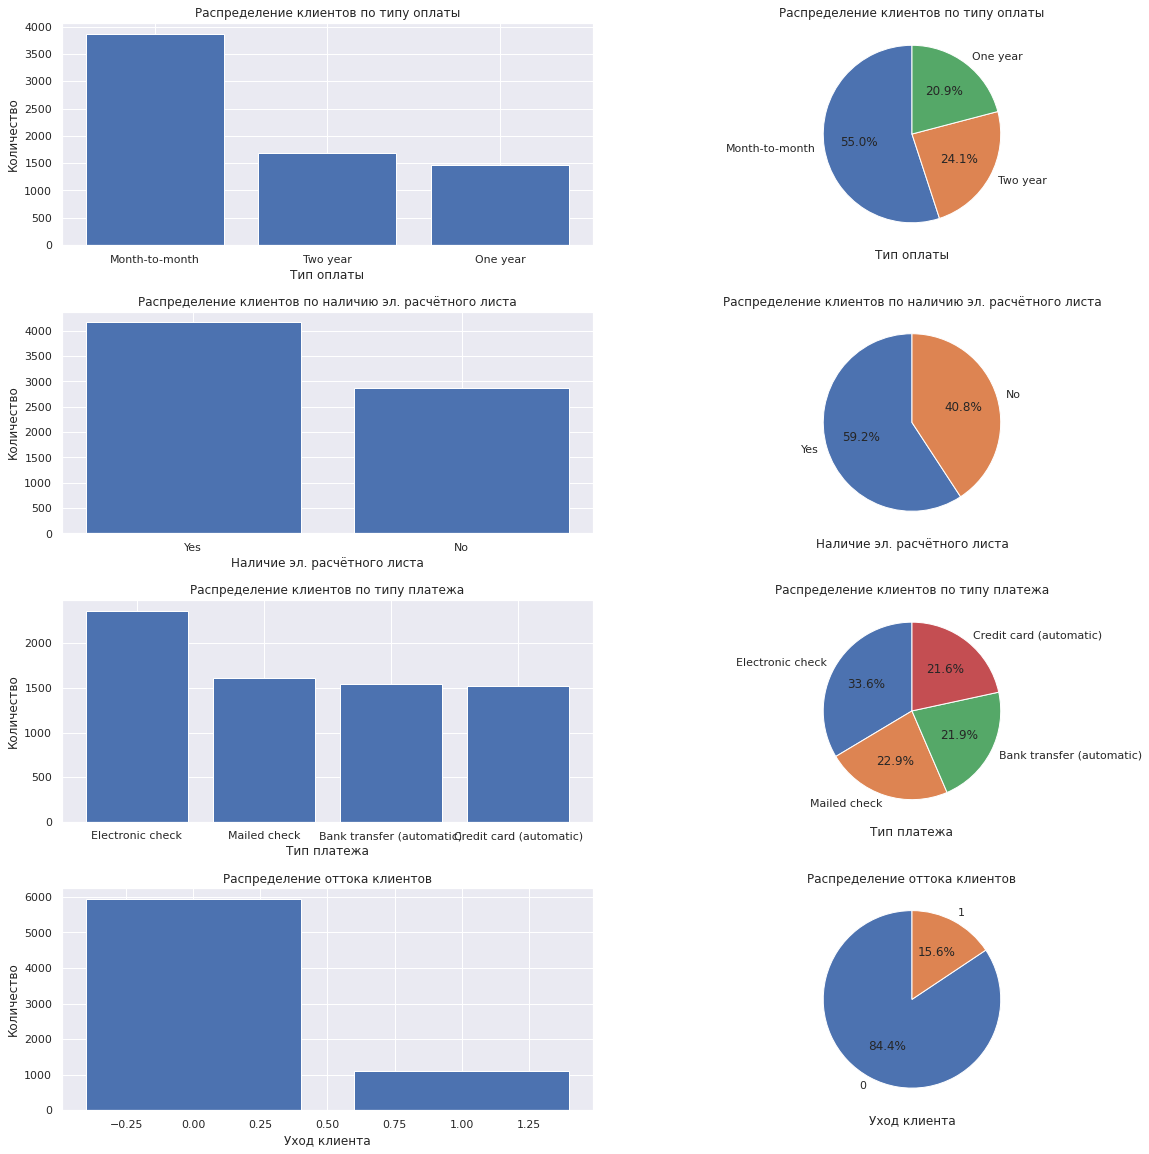

In [16]:
obj_cdata_cols = contract_datav2.columns.drop(['contract_dur', 'total_charges', 'monthly_charges'])
obj_cdata_titles = [
    'Распределение клиентов по типу оплаты',
    'Распределение клиентов по наличию эл. расчётного листа',
    'Распределение клиентов по типу платежа',
    'Распределение оттока клиентов'
]

obj_cdata_xlabels = [
    'Тип оплаты',
    'Наличие эл. расчётного листа',
    'Тип платежа',
    'Уход клиента'
]

double_plots(contract_datav2, obj_cdata_cols, obj_cdata_xlabels, obj_cdata_titles, (20, 20))

**Какие выводы можно сделать:**

- Большинство пользователей предпочитает оплачивать услуги ежемесячно
- 59% клиентов имеет электронный расчётный лист
- 43% пользователей оплачивают услуги автоматически, пользуясь кредитными картами и банковскими переводами
- Распределение оттока клиентов говорит о дисбаланс классов. Так что в будущем будем использовать метрику ROC-AUC, чтобы этот дисбаланс не повлиял на качество модели

Посмотрим на распределение количественных переменных

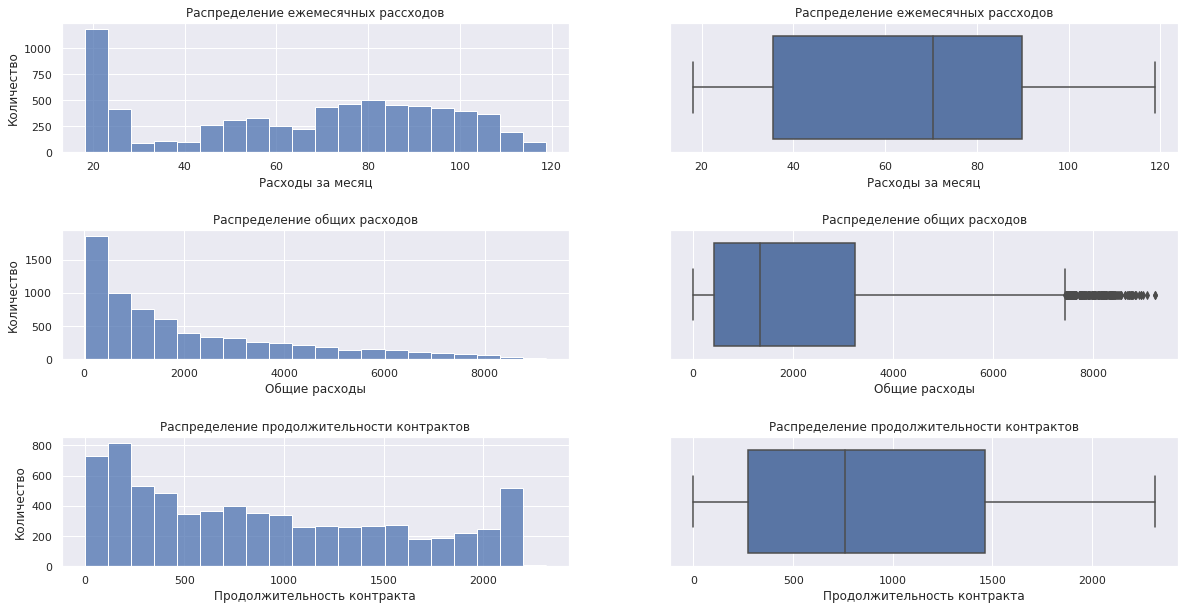

In [17]:
fig, axs = plt.subplots(3, 2, figsize=(20, 10))

sns.histplot(data=contract_datav2, x='monthly_charges', bins=20, ax=axs[0, 0])
axs[0,0].set_xlabel('Расходы за месяц')
axs[0,0].set_ylabel('Количество')
axs[0,0].set_title('Распределение ежемесячных рассходов')

sns.boxplot(contract_datav2['monthly_charges'], orient='h', ax=axs[0, 1])
axs[0,1].set_xlabel('Расходы за месяц')
axs[0,1].set_title('Распределение ежемесячных рассходов')

sns.histplot(data=contract_datav2, x='total_charges', bins=20, ax=axs[1, 0])
axs[1,0].set_xlabel('Общие расходы')
axs[1,0].set_ylabel('Количество')
axs[1,0].set_title('Распределение общих расходов')

sns.boxplot(contract_datav2['total_charges'], orient='h', ax=axs[1, 1])
axs[1,1].set_xlabel('Общие расходы')
axs[1,1].set_title('Распределение общих расходов')

sns.histplot(data=contract_datav2, x='contract_dur', bins=20, ax=axs[2, 0])
axs[2,0].set_xlabel('Продолжительность контракта')
axs[2,0].set_ylabel('Количество')
axs[2,0].set_title('Распределение продолжительности контрактов')

sns.boxplot(contract_datav2['contract_dur'], orient='h', ax=axs[2, 1])
axs[2,1].set_xlabel('Продолжительность контракта')
axs[2,1].set_title('Распределение продолжительности контрактов')

plt.subplots_adjust(wspace=0.2, hspace=0.6)
plt.show();

- Аномальные значения отсутствуют
- Большая часть пользоваетелй тратит на услуги менее 50, в то время как остальные клиенты распределены по расходам равномерно(можно категоризировать)
- Большинство клиентов пользуется услугами компании менее 1000 дней

#### Корреляционный анализ

Проверим, как признаки влияют на целевую переменную

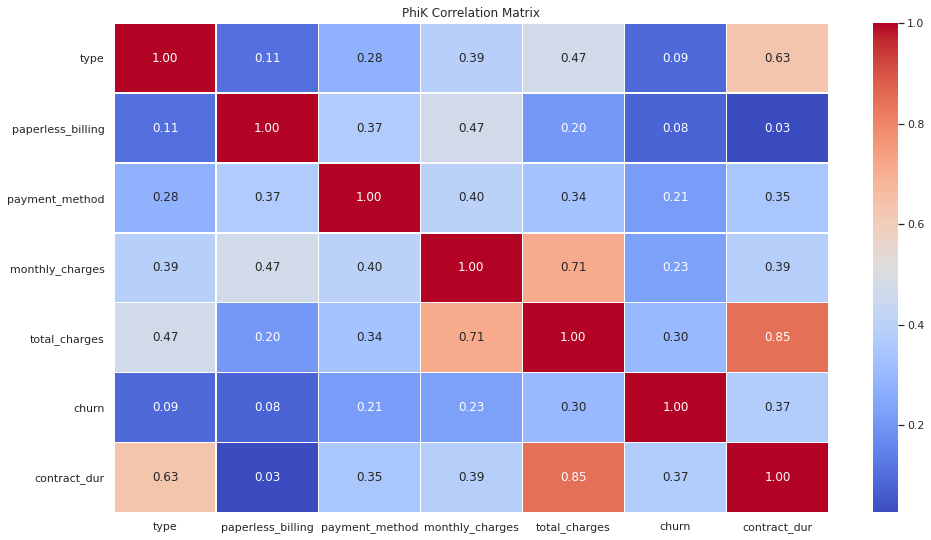

In [18]:
corr_matrix = contract_datav2 \
                .phik_matrix(interval_cols=['monthly_charges', 'total_charges', 'contract_dur', 'churn'])

plt.figure(figsize=(16, 9))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('PhiK Correlation Matrix')
plt.show();

- total_charges и contract_dur имеют сильню корреляцию, так как чем больше время пользования, тем больше расходы клиента
- Также заметна связь между contract_dur и type - то есть пользователи, которые имеют годовой или более тип оплаты, логично имеют более длинный контракт
- Все признаки имеют слабую, однако значимую корреляцию с таргетом

Посмотрим на графиках, как признаки влияют на отток клиентов

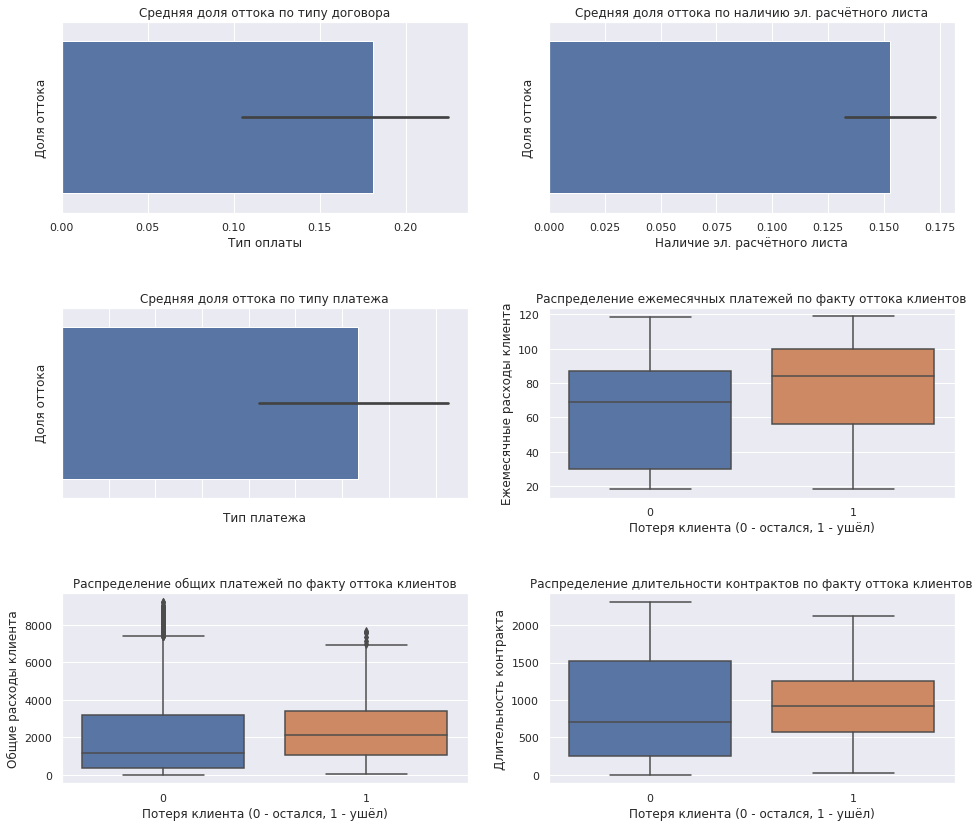

In [19]:
fig, axs = plt.subplots(3, 2, figsize=(16, 14))

sns.barplot(contract_datav2.groupby('type')['churn'].mean(), ax=axs[0, 0])
axs[0, 0].set_title('Средняя доля оттока по типу договора')
axs[0, 0].set_ylabel('Доля оттока')
axs[0, 0].set_xlabel('Тип оплаты')

sns.barplot(contract_datav2.groupby('paperless_billing')['churn'].mean(), ax=axs[0, 1])
axs[0, 1].set_title('Средняя доля оттока по наличию эл. расчётного листа')
axs[0, 1].set_ylabel('Доля оттока')
axs[0, 1].set_xlabel('Наличие эл. расчётного листа')

sns.barplot(contract_datav2.groupby('payment_method')['churn'].mean(), ax=axs[1, 0])
axs[1, 0].set_title('Средняя доля оттока по типу платежа')
axs[1, 0].set_ylabel('Доля оттока')
axs[1, 0].set_xlabel('Тип платежа')
axs[1, 0].set_xticklabels(axs[1, 0].get_xticklabels(), rotation=15, ha='center')

sns.boxplot(data=contract_datav2, x='churn', y='monthly_charges', ax=axs[1, 1])
axs[1, 1].set_title('Распределение ежемесячных платежей по факту оттока клиентов')
axs[1, 1].set_ylabel('Ежемесячные расходы клиента')
axs[1, 1].set_xlabel('Потеря клиента (0 - остался, 1 - ушёл)')

sns.boxplot(data=contract_datav2, x='churn', y='total_charges', ax=axs[2, 0])
axs[2, 0].set_title('Распределение общих платежей по факту оттока клиентов')
axs[2, 0].set_ylabel('Общие расходы клиента')
axs[2, 0].set_xlabel('Потеря клиента (0 - остался, 1 - ушёл)')

sns.boxplot(data=contract_datav2, x='churn', y='contract_dur', ax=axs[2, 1])
axs[2, 1].set_title('Распределение длительности контрактов по факту оттока клиентов')
axs[2, 1].set_ylabel('Длительность контракта')
axs[2, 1].set_xlabel('Потеря клиента (0 - остался, 1 - ушёл)')

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show();

- Клиенты с ежемесячным типом оплаты немного реже отказываются от услуг
- Отсутствие эл. расчётного листа также уменьшает вероятность оттока клиента
- Клиенты, оплачивающие услуги с помощью электронного чека или почтой(особенно) реже отказываются от услуг
- Увеличенные расходы пользователя немногим повышают вероятноть его ухода

**Итоги анализа информации о договоре:**

- Исправлена ошибка в типе данных столбца *total_charges*
- Добавлен целевой признак *churn* на основе информации из *end_date*
- Добавлен новый признак *contract_dur*, отвечающий за продолжительность контракта(вместо *end_date и begin_date*)
- Проведён анализ распределения данных (замечен дисбаланс классов в таргете)
- Проведён корреляционный анализ (все признаки были оставлены)

### Анализ персональных данных

#### Предобработка

Проверим данные на наличие дубликатов

In [20]:
print('Количество явных дубликатов:', personal_datav1.duplicated().sum())

Количество явных дубликатов: 0


In [21]:
for col in personal_datav1.select_dtypes(include='object'):
    print(f' {col}: {personal_datav1[col].unique()}\n')

 customer_id: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']

 gender: ['Female' 'Male']

 partner: ['Yes' 'No']

 dependents: ['No' 'Yes']



Дубликаты не обнаружены

Сделаем *customer_id* индексом, как и в датасете о договоре

In [22]:
personal_datav2 = personal_datav1.set_index('customer_id')

#### Исследовательский анализ

Посмотрим на распределение значений в признаках

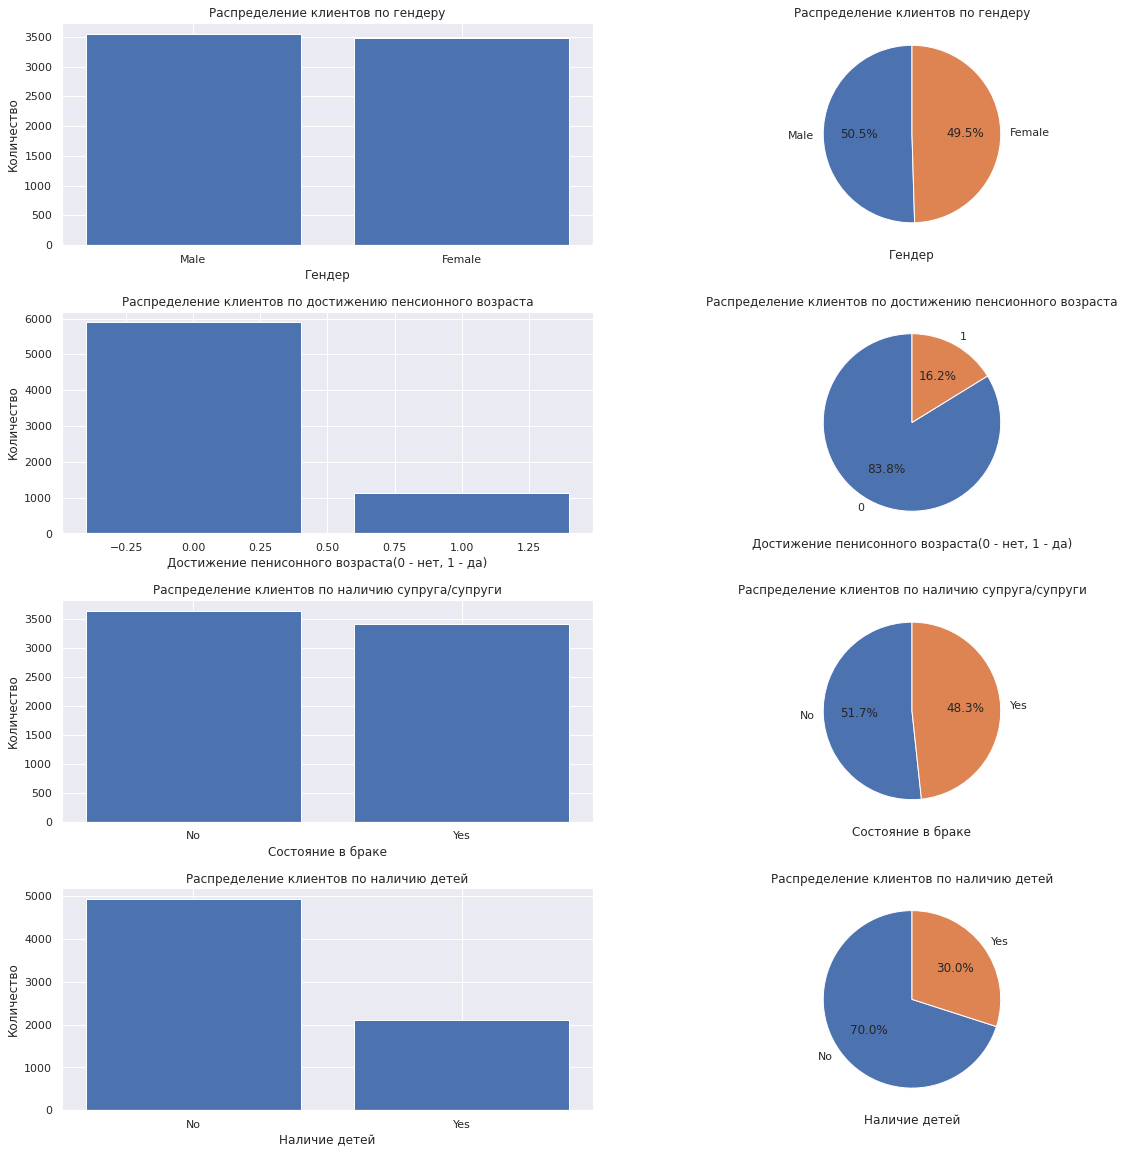

In [23]:
obj_pdata_cols = personal_datav2.columns
obj_pdata_titles = [
    'Распределение клиентов по гендеру',
    'Распределение клиентов по достижению пенсионного возраста',
    'Распределение клиентов по наличию супруга/супруги',
    'Распределение клиентов по наличию детей'
]

obj_pdata_xlabels = [
    'Гендер',
    'Достижение пенисонного возраста(0 - нет, 1 - да)',
    'Состояние в браке',
    'Наличие детей'
]

double_plots(personal_datav2, obj_pdata_cols, obj_pdata_xlabels, obj_pdata_titles, (20, 20))

- Пользователи распределены равномерно по гендеру и достижению пенсионного возраста
- Большинсто клиентов не состоит в браке 

### Анализ информации об интернет-услугах

#### Предобработка

In [24]:
print('Количество явных дубликатов:', internet_datav1.duplicated().sum())

Количество явных дубликатов: 0


In [25]:
for col in internet_datav1.select_dtypes(include='object'):
    print(f' {col}: {internet_datav1[col].unique()}\n')

 customer_id: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']

 internet_service: ['DSL' 'Fiber optic']

 online_security: ['No' 'Yes']

 online_backup: ['Yes' 'No']

 device_protection: ['No' 'Yes']

 tech_support: ['No' 'Yes']

 streaming_t_v: ['No' 'Yes']

 streaming_movies: ['No' 'Yes']



Дубликаты отсутствуют

In [26]:
internet_datav2 = internet_datav1.set_index('customer_id')

Добавим столбец(*internet_services_num*), говорящий о количестве интернет-услуг, которые подключил пользователь

In [27]:
# количество 'Yes' + 1(подключение интернета есть всегда)
internet_datav2['internet_services_num'] = internet_datav2.apply(lambda row: sum(1 for i in row if i == 'Yes'), axis=1) +1

#### Исследовательский анализ

Посмотрим, сколько всего пользователей интернет-услуг

In [28]:
internet_usrs_num = internet_datav2.shape[0]
overall_usrs_num = contract_datav2.shape[0]
print('Количество клиентов, пользующихся интернетом:', internet_usrs_num)
print(f'Процент клиентов, пользующихся интернетом: {round(internet_usrs_num/overall_usrs_num * 100)}%')

Количество клиентов, пользующихся интернетом: 5517
Процент клиентов, пользующихся интернетом: 78%


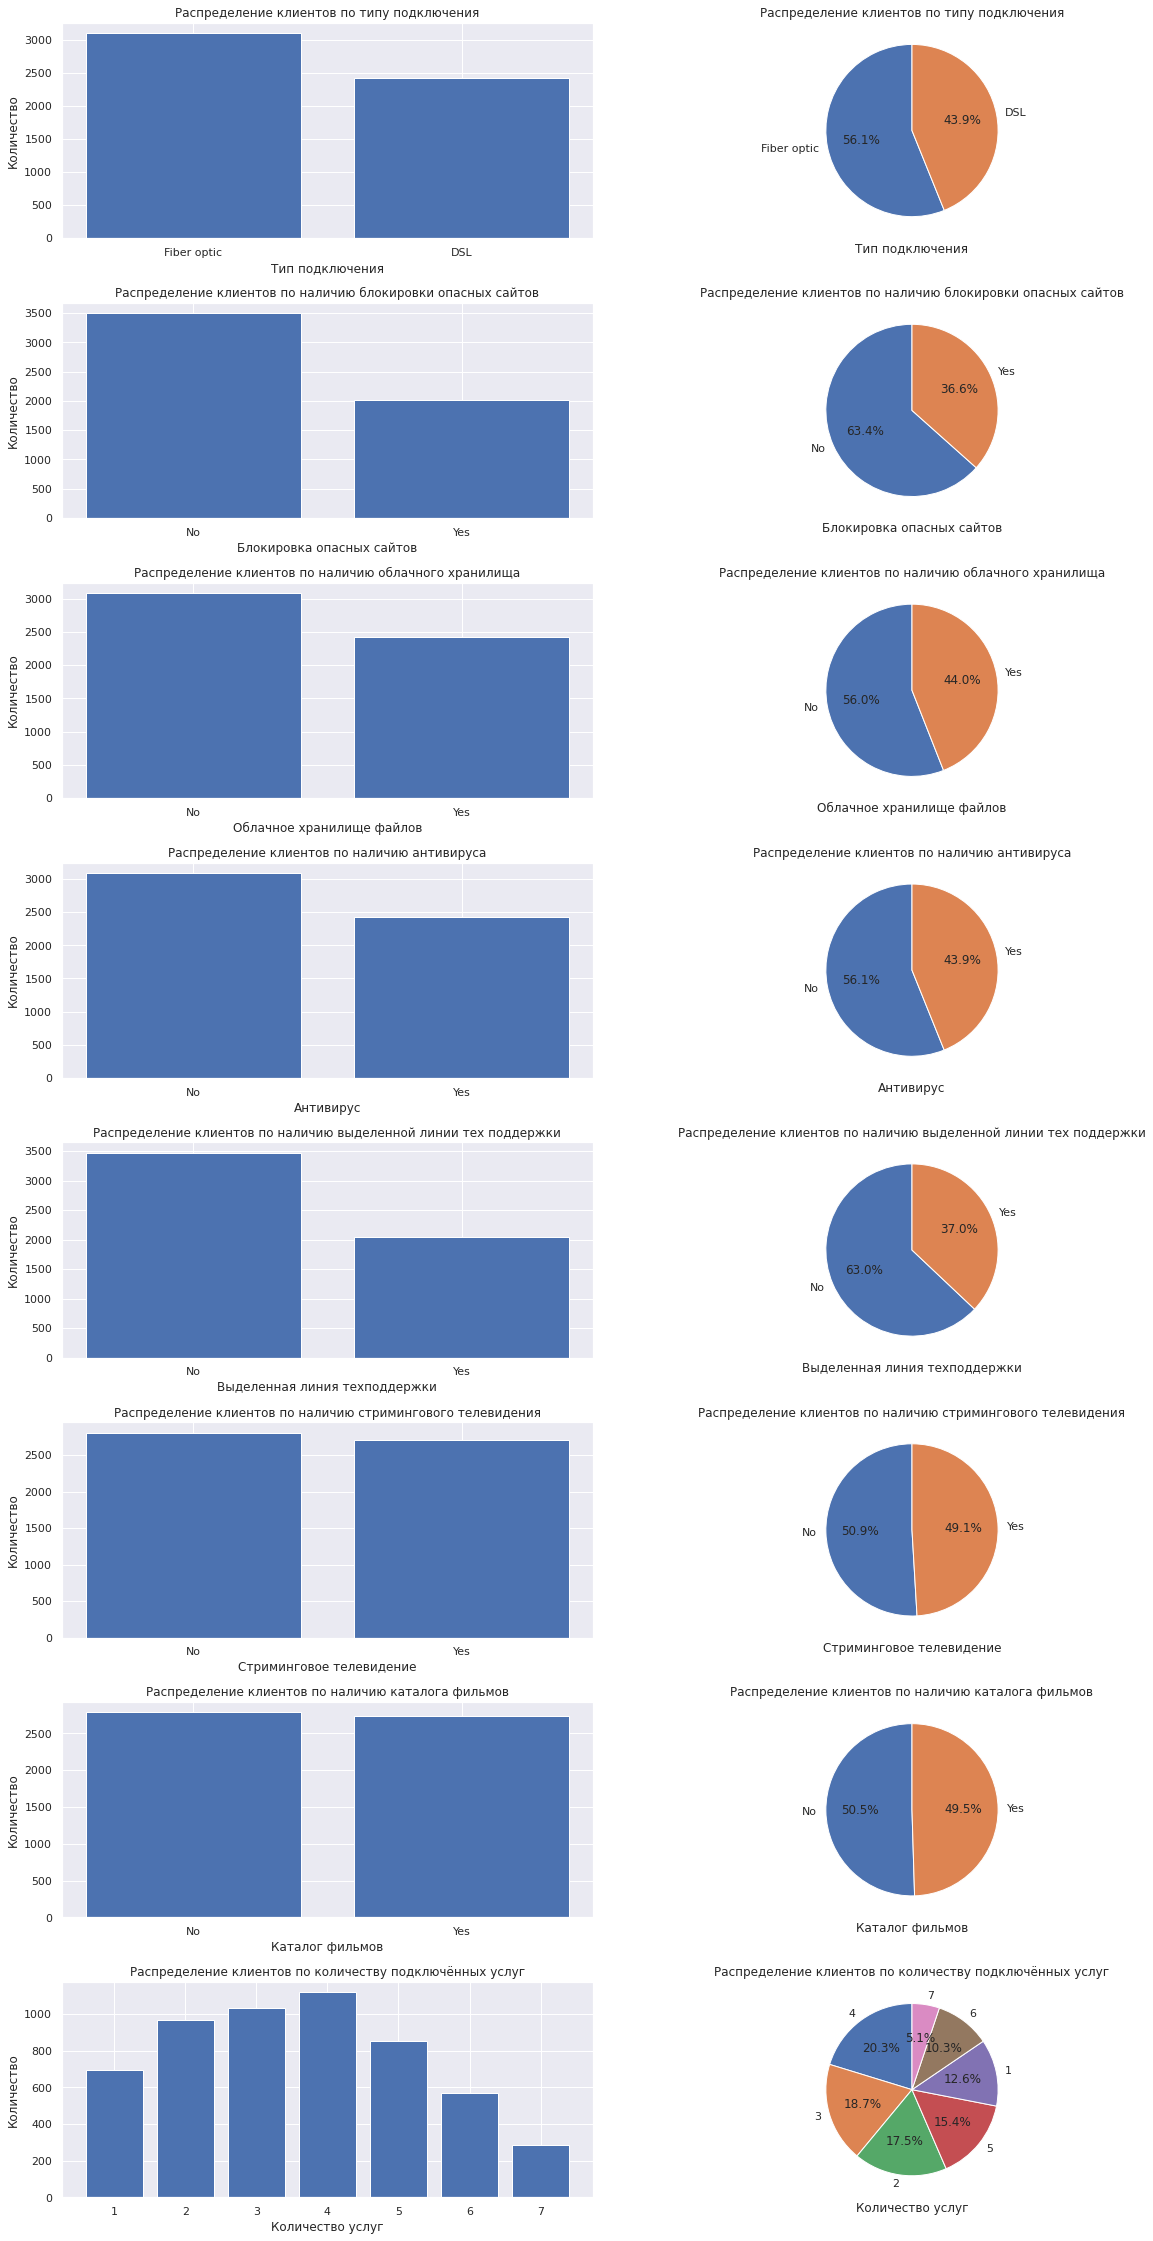

In [29]:
obj_idata_cols = internet_datav2.columns
obj_idata_titles = [
    'Распределение клиентов по типу подключения',
    'Распределение клиентов по наличию блокировки опасных сайтов',
    'Распределение клиентов по наличию облачного хранилища',
    'Распределение клиентов по наличию антивируса',
    'Распределение клиентов по наличию выделенной линии тех поддержки',
    'Распределение клиентов по наличию стримингового телевидения',
    'Распределение клиентов по наличию каталога фильмов',
    'Распределение клиентов по количеству подключённых услуг'
]

obj_idata_xlabels = [
    'Тип подключения',
    'Блокировка опасных сайтов',
    'Облачное хранилище файлов',
    'Антивирус',
    'Выделенная линия техподдержки',
    'Стриминговое телевидение',
    'Каталог фильмов',
    'Количество услуг'
]

double_plots(internet_datav2, obj_idata_cols, obj_idata_xlabels, obj_idata_titles, (20, 40))

- Большинство клиентов выбирает оптоволоконный кабель для подключения интернета вместо телефонной линии
- Нет услуги, которая была бы популярна у большинства(>50%) клиентов
- Пользователи зачастую имеют от 2 до 5 подключённых услуг(70%)

**Итоги анализа информации об интернет-услугах:**

- Произведена проверка данных на наличие дубликатов(их не оказалось)
- Добавлен признак *internet_services_num* - количество интернет-услуг
- 78% клиентов пользуются интернет-услугами
- Проведён анализ распределения данных

### Анализ информации об услугах телефонии

In [30]:
print('Количество явных дубликатов:', phone_datav1.duplicated().sum(), end='\n\n')

for col in phone_datav1.select_dtypes(include='object'):
    print(f' {col}: {phone_datav1[col].unique()}\n')

Количество явных дубликатов: 0

 customer_id: ['5575-GNVDE' '3668-QPYBK' '9237-HQITU' ... '2234-XADUH' '8361-LTMKD'
 '3186-AJIEK']

 multiple_lines: ['No' 'Yes']



Дубликаты отсутствуют

In [31]:
phone_datav2 = phone_datav1.set_index('customer_id')

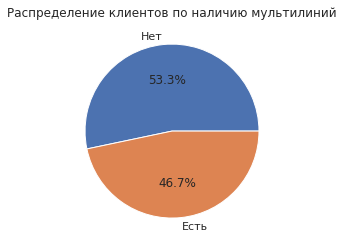

In [32]:
mlines_count = phone_datav1['multiple_lines'].value_counts()

plt.pie(mlines_count, labels=['Нет', 'Есть'], autopct='%1.1f%%',)
plt.title('Распределение клиентов по наличию мультилиний')
plt.show();

- Большинство клиентов предпочитает не подключать доступ к мультилиниям

**Итоги исследовательского анализа и предобработки данных:**

- Все датасеты были проверены на наличие дубликатов(их не оказалось)
- Были исправлен неверный тип данных в признаке *total_charges*
- Добавлены новые признаки: churn(уход клиента), contract_dur(продолжительность контракта), internet_services_num(количество интернет-услуг)
- Удалены ненужные признаки: begin_date, end_date, customer_id(заменён на индекс)
- Проведён анализ распределения каждого датасета(никаких анормалий)

## Объединение данных

У нас 4 таблицы, в которых разное количество объектов. Посмотрим, какие клиенты являются общими в датасетах. За основную таблицу будем считать contract_datav2, так как в ней больше всего объектов и больше всего информации.

In [33]:
print('Количество общих объектов в contract_datav2 и personal_datav2:', len([i for i in contract_datav2.index if i in personal_datav2.index]))
print('Количество общих объектов в contract_datav2 и internet_datav2:', len([i for i in contract_datav2.index if i in internet_datav2.index]))
print('Количество общих объектов в contract_datav2 и phone_datav2:', len([i for i in contract_datav2.index if i in phone_datav2.index]))

Количество общих объектов в contract_datav2 и personal_datav2: 7043
Количество общих объектов в contract_datav2 и internet_datav2: 5517
Количество общих объектов в contract_datav2 и phone_datav2: 6361


Оказывается так, что все пользователи из **personal_datav2** и **contract_datav2** распределены по разным таблицам. Так, в **internet_datav2** находятся только те клиенты, которые подключили интернет, а в **phone_datav2** подключившие мультилинии.

Объединим все датафреймы в таблицу **telecom_data**

In [34]:
telecom_data = pd.concat([contract_datav2, personal_datav2, internet_datav2, phone_datav2], axis=1)

In [35]:
telecom_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   type                   7043 non-null   object 
 1   paperless_billing      7043 non-null   object 
 2   payment_method         7043 non-null   object 
 3   monthly_charges        7043 non-null   float64
 4   total_charges          7043 non-null   float64
 5   churn                  7043 non-null   int64  
 6   contract_dur           7043 non-null   int64  
 7   gender                 7043 non-null   object 
 8   senior_citizen         7043 non-null   int64  
 9   partner                7043 non-null   object 
 10  dependents             7043 non-null   object 
 11  internet_service       5517 non-null   object 
 12  online_security        5517 non-null   object 
 13  online_backup          5517 non-null   object 
 14  device_protection      5517 non-null   object 

Заметим, что появилиль пропущенные значения. Примечательно, что все(кроме *internet_services_num*) они находятся в категориальных столбцах. Мы можем заменить их на значение 'No', то есть услуга не была подключена, однако должна же быть причина, по которой не все пользователи находятся в этих таблицах(может быть их специально не уведомляли об услуге или она намеренно была отключена), так что заменим все пропуски на значение "Not stated"

In [36]:
# пропуски в internet_services_num заменим на 0
telecom_data['internet_services_num'].fillna(0, inplace=True)
telecom_data.fillna('Not stated', inplace=True)

**В результате объединения данных:**

- Была создана новая таблица  **telecom_data**
- В новой таблице пропущенные значения были заменены на "Not stated"

## Исследовательский анализ и предобработка данных объединённого датафрейма

### Исследовательский анализ

Посмотрим не появились ли какие-нибудь некорректности в данных после объединения

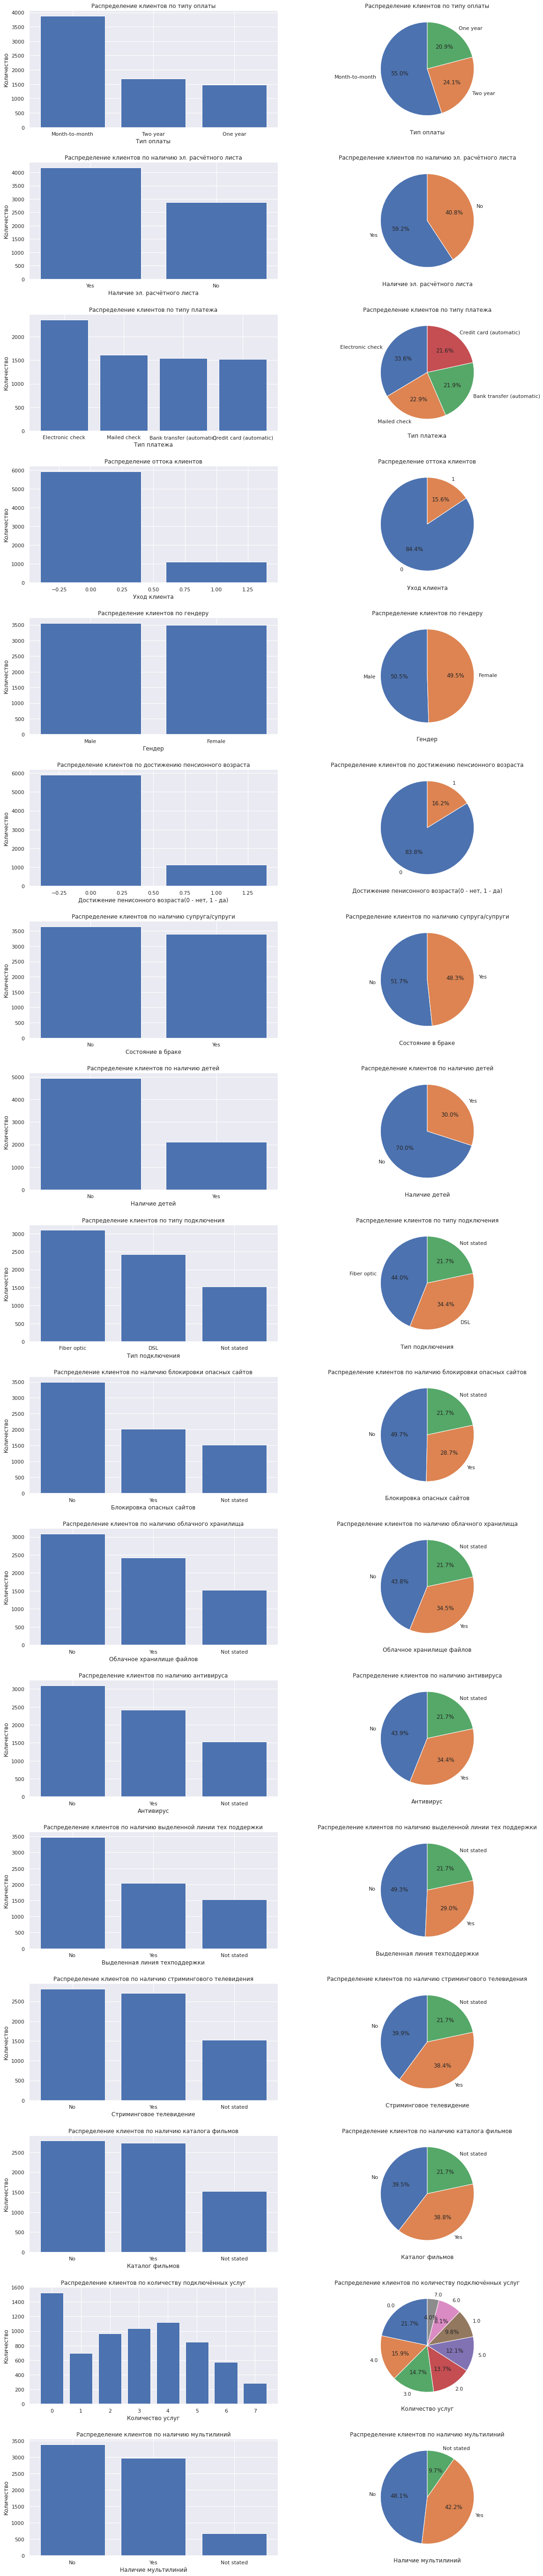

In [37]:
obj_tdata_cols = telecom_data.columns.drop(['contract_dur', 'total_charges', 'monthly_charges'])

obj_tdata_titles = obj_cdata_titles + obj_pdata_titles + obj_idata_titles + ['Распределение клиентов по наличию мультилиний']
obj_tdata_xlabels = obj_cdata_xlabels + obj_pdata_xlabels + obj_idata_xlabels + ['Наличие мультилиний']

double_plots(telecom_data, obj_tdata_cols, obj_tdata_xlabels, obj_tdata_titles, (20, 100))

- Аномальных распределений нет
- 20% клиентов не подключают интернет, в то время как только 9% пользователей не имеет мультилиний, что говорит о большей популярности данной услуги

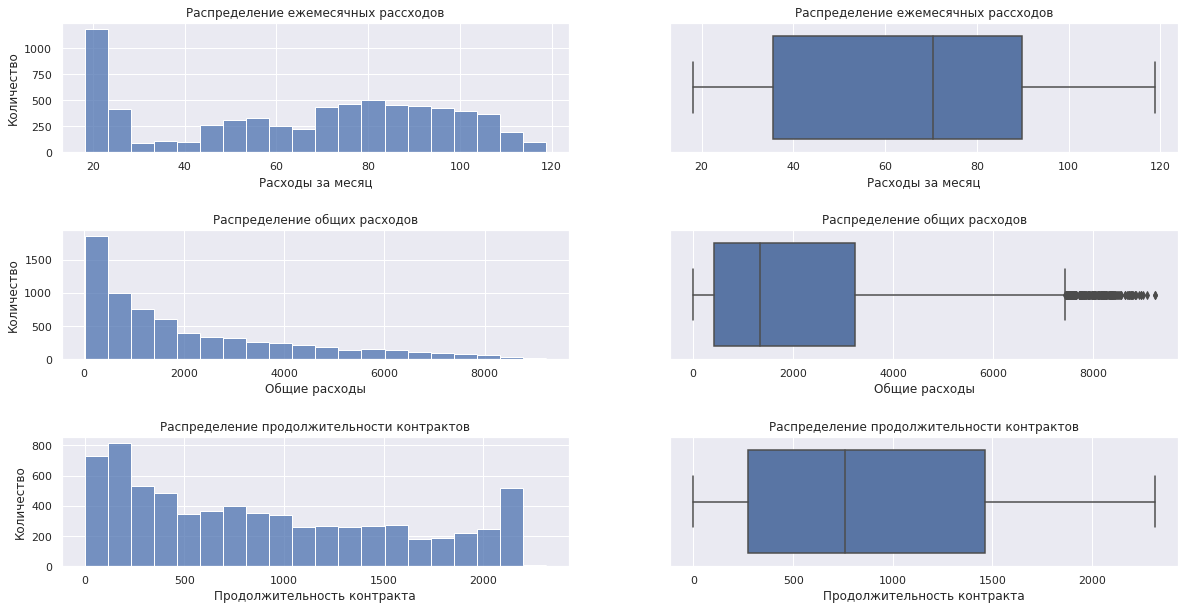

In [38]:
fig, axs = plt.subplots(3, 2, figsize=(20, 10))

sns.histplot(data=telecom_data, x='monthly_charges', bins=20, ax=axs[0, 0])
axs[0,0].set_xlabel('Расходы за месяц')
axs[0,0].set_ylabel('Количество')
axs[0,0].set_title('Распределение ежемесячных рассходов')

sns.boxplot(telecom_data['monthly_charges'], orient='h', ax=axs[0, 1])
axs[0,1].set_xlabel('Расходы за месяц')
axs[0,1].set_title('Распределение ежемесячных рассходов')

sns.histplot(data=telecom_data, x='total_charges', bins=20, ax=axs[1, 0])
axs[1,0].set_xlabel('Общие расходы')
axs[1,0].set_ylabel('Количество')
axs[1,0].set_title('Распределение общих расходов')

sns.boxplot(telecom_data['total_charges'], orient='h', ax=axs[1, 1])
axs[1,1].set_xlabel('Общие расходы')
axs[1,1].set_title('Распределение общих расходов')

sns.histplot(data=telecom_data, x='contract_dur', bins=20, ax=axs[2, 0])
axs[2,0].set_xlabel('Продолжительность контракта')
axs[2,0].set_ylabel('Количество')
axs[2,0].set_title('Распределение продолжительности контрактов')

sns.boxplot(telecom_data['contract_dur'], orient='h', ax=axs[2, 1])
axs[2,1].set_xlabel('Продолжительность контракта')
axs[2,1].set_title('Распределение продолжительности контрактов')

plt.subplots_adjust(wspace=0.2, hspace=0.6)
plt.show();

- В количественных признаках изменений также нет

### Корреляционный анализ

Взглянем на всю тепловую карту нашего датасета

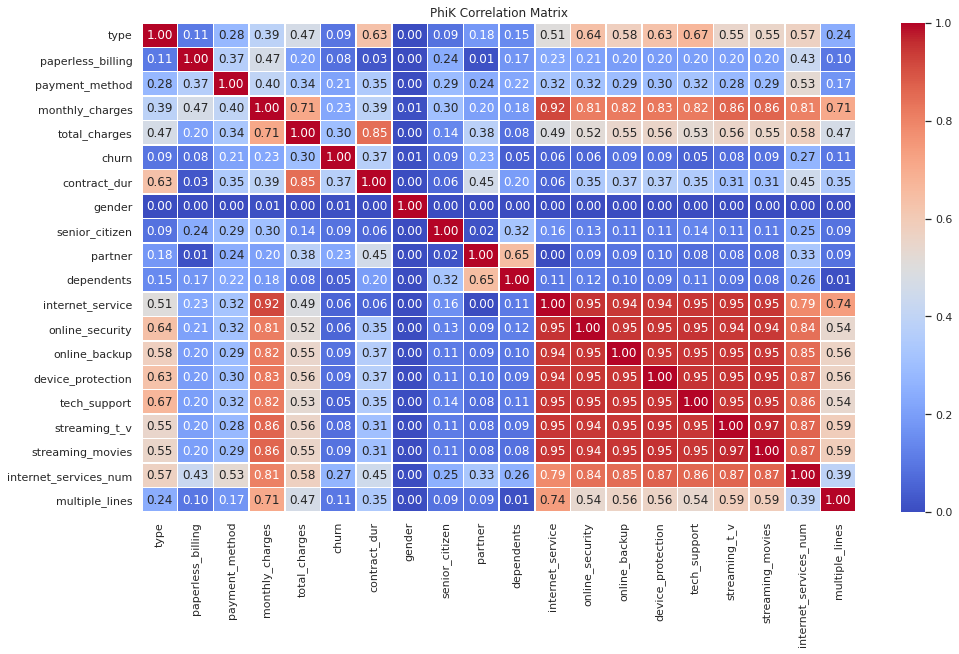

In [39]:
corr_matrix = telecom_data \
                .phik_matrix(interval_cols=['monthly_charges', 'total_charges', 'contract_dur'])

plt.figure(figsize=(16, 9))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('PhiK Correlation Matrix')
plt.show();

- Явня мультиколлинеарность всех интернет-услуг между собой(*internet_service, online_security, online_backup, device_protection, tech_support, streaming_t_v, streaming_movies*). Cами по себе они практически никак не влияют на таргет, так что можно оставить только один признак(online_backup), который больше всего взаимосвязан с *churn* 
- *total_charges* имеет среднюю корреляцию с признаками интернет-услуг и высокую корреляцию с продолжительностью контракта(*contract_dur*)
- *monthly_charges* также коррелирует с признаками интернет усллуг(но сильнее, чем *total_charges*)
- *churn имеет* слабую корреляцию с *payment_method, monthly_charges, total_charges, contract_dur, partner, internet_services_num и multiple_lines*, в то время как остальные признаки практически не влияют на таргет
- *gender* стоит удалить, так как он вообще не связан с *churn*

Рассмотрим подробнее, как признаки *partner и internet_services_num* соотносятся с таргетом

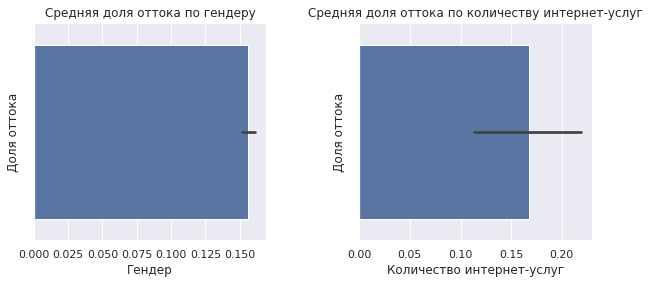

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

sns.barplot(telecom_data.groupby('gender')['churn'].mean(), ax=axs[0])
axs[0].set_title('Средняя доля оттока по гендеру')
axs[0].set_ylabel('Доля оттока')
axs[0].set_xlabel('Гендер')

sns.barplot(telecom_data.groupby('internet_services_num')['churn'].mean(), ax=axs[1])
axs[1].set_title('Средняя доля оттока по количеству интернет-услуг')
axs[1].set_ylabel('Доля оттока')
axs[1].set_xlabel('Количество интернет-услуг')


plt.subplots_adjust(wspace=0.4, hspace=0.5)
plt.show();

- Мужчины немного чаще отказываются от услуг компании
- Большое количество подключенных интернет-услуг также может сподвигнуть человека к уходу

Теперь избавимся от мультколлинеарных столбцов и признака *gender*

In [41]:
telecom_data2 = telecom_data.drop(
    ['internet_service', 'online_security',
     'device_protection', 'tech_support',
     'streaming_t_v', 'streaming_movies', 'gender'],
    axis=1)

In [42]:
telecom_data2.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,contract_dur,senior_citizen,partner,dependents,online_backup,internet_services_num,multiple_lines
customer_id,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,0,31,0,Yes,No,Yes,2.0,Not stated
5575-GNVDE,One year,No,Mailed check,56.95,2071.84,0,1036,0,No,No,No,3.0,No
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,0,123,0,No,No,Yes,3.0,No
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371,0,No,No,No,4.0,Not stated
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,0,153,0,No,No,No,1.0,No


**В результате корреляционного анализа:**

- Представлена тепловая карта датасета
- Найдены новые зависимости переменных
- Изучены соответсвия между новыми признаками и таргетом
- Создана новая таблица *telecom_data2*, в которой устранены проблемы мультиколлинеарности и которая содержит только значимые признаки

**В результате исследовательского анализа данных и предобработки объединённого датасета:**

- Подтверждена целостность данных
- Создан новый датасет telecom_data2 на основе выводов корреляционного анализа

## Подготовка данных

Разделим выборки на тренировочную и тестовую

In [43]:
X = telecom_data2.drop('churn', axis=1)
y = telecom_data2['churn']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    stratify=y,
    random_state=RANDOM_STATE
)

Создадим пайплайны для подготовки категориальных признаков. Также не забудем про пропущенные значения и импутирем их с помощью SimpleImputer

In [44]:
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
    ]
)

In [45]:
ord_pipe = Pipeline(
    [
        ('simpleImputer_ord', SimpleImputer(strategy='most_frequent')),
        ('encoder', OrdinalEncoder(
            categories=[['Month-to-month', 'One year', 'Two year']]
            )
        )
    ]
)

Выберем какую кодировку будут проходить разные признаки в датасете

In [46]:
num_cols = ['monthly_charges', 'total_charges',
            'contract_dur', 'internet_services_num']
ord_cols = ['type']
ohe_cols = ['paperless_billing', 'payment_method', 'partner',
           'dependents', 'online_backup', 'multiple_lines']


Создадим общий пайплайн, который будет подготавливать наши данные

In [47]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_cols),
     ('ord', ord_pipe, ord_cols),
     ('num', MinMaxScaler(), num_cols)
    ], 
    remainder='passthrough'
)

**В результате подготовки данных:**

- Данные были разделены на тренировочную и тестовую выборки
- Создан пайплайн, который будет кодировать данные перед подачей модели

## Обучение моделей машинного обучения

Как уже ранее было указано, в качестве метрики модели будем использовать ROC-AUC, так как в таргете присутствует дисбаланс

In [48]:
# отображает время обучения, время предсказания, ROC-AUC модели и добавляет все эти параметры в словарь
def find_preprocessing_time(model):
    results_df = pd.DataFrame(model.cv_results_)
    best_score_df = results_df[results_df['rank_test_score'] == 1]

    model_stat = {'Время обучения': round(best_score_df['mean_fit_time'].iloc[0], 3),
                  'Время предсказания': round(best_score_df['mean_score_time'].iloc[0], 3),
                  'ROC-AUC': round(model.best_score_, 3)}
    for key, val in model_stat.items():
        print(f'{key}: {val}')
    
    return model_stat

Построим пайплайн с логистической регрессией

In [49]:
log_pipe = Pipeline([
    ('preprocessor', data_preprocessor),
    ('log', LogisticRegression(max_iter=3000, random_state=RANDOM_STATE))
])

In [50]:
log_params = {
    'log__C': [1.5, 3, 7, 10, 20, 30, 35],
}

In [51]:
log_search = GridSearchCV(
    log_pipe,
    log_params,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

log_search.fit(X_train, y_train)
log_stat = find_preprocessing_time(log_search)
print('Параметры модели:', log_search.best_params_)

Время обучения: 0.395
Время предсказания: 0.124
ROC-AUC: 0.754
Параметры модели: {'log__C': 30}


Неплохая точность модели и отличная скорость

Посмотрим, как покажет себя более сложный алгоритм CatBoost

In [52]:
catboost_model = CatBoostClassifier(verbose=0, random_state=RANDOM_STATE)

In [53]:
catboost_params = {
    'n_estimators': [500, 700],
    'depth': range(2, 7, 2),
    'learning_rate': [0.5, 1, 2],
    'l2_leaf_reg': [0.5, 1, 2]
}

In [54]:
catboost_search = GridSearchCV(
    catboost_model,
    catboost_params,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

catboost_search.fit(
    X_train,
    y_train,
    cat_features=ord_cols + ohe_cols,
    early_stopping_rounds=100,
    verbose=0)
catboost_stat = find_preprocessing_time(catboost_search)
print('Параметры модели:', catboost_search.best_params_)

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease l

Время обучения: 2.454
Время предсказания: 0.006
ROC-AUC: 0.927
Параметры модели: {'depth': 2, 'l2_leaf_reg': 0.5, 'learning_rate': 0.5, 'n_estimators': 500}


Отличая точность, но большое время обучения

Попробуем использовать ансамбль сложных моделей

In [55]:
rf_model = RandomForestClassifier(n_estimators=450, random_state=RANDOM_STATE)
gb_model = GradientBoostingClassifier(n_estimators=450, random_state=RANDOM_STATE)
lgb_model = LGBMClassifier(n_estimators=450, verbose=0, random_state=RANDOM_STATE)

ensemble = VotingClassifier(
    estimators=[
        ('lgb', lgb_model),
        ('random_forest', rf_model),
        ('gradient_boost', gb_model)
    ],
    voting='soft'
)

In [56]:
ensemble_pipe = Pipeline([
    ('preprocessor', data_preprocessor),
    ('ensemble', ensemble)
])

In [57]:
ensemble_score = cross_val_score(ensemble_pipe, X_train, y_train, cv=5, scoring='roc_auc').mean()

start_l = time.time()
ensemble_pipe.fit(X_train, y_train)
finish_l =  time.time()

start_p = time.time()
ensemble_pipe.predict_proba(X_test)[:, 1]
finish_p =  time.time()

ensemble_stat = {'Время обучения': round(finish_l-start_l, 3),
           'Время предсказания': round(finish_p-start_p, 3),
           'ROC-AUC': round(ensemble_score, 3)}

for key, val in ensemble_stat.items():
    print(f'{key}: {val}')

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000331 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing

Неплохая скорость и хорошая точность

**В результате обучения моделей:**

- Было обучено три модели машинного обучения: LogisticRegression, CatBoostClassifier, Ensemble(RF, GB, LGB)

## Выбор лучшей модели

Оценим все модели и выберем лучшую

In [58]:
models = ['LogisticRegression', 'CatBoostClassifier', 'Ensemble(LGB, RF, GB)']
models_info = [log_stat, catboost_stat, ensemble_stat]

pd.DataFrame(models_info, index=models)

,Время обучения,Время предсказания,ROC-AUC
LogisticRegression,0.395,0.124,0.754
CatBoostClassifier,2.454,0.006,0.927
"Ensemble(LGB, RF, GB)",10.870,0.302,0.887


Как можно заметить по этой таблице, характеристики моделей сильно разнятся, так что всё зависит от того, что для заказчика важнее. Однако, я считаю, что CatBoostClassifier подходит для работы с заказчиком, так все характеристики этой модели хороши: точность предсказания значительно лучше, чем у остальных моделей, время предсказания небольшое, но время обучения довольно велико.

Если заказчику очень важна скорость обучения, в то время как сама точность модели не особо важна, то выбор падает LogisticRegression

Если заказчику важны только точность модели и  скорость предсказания, а временем обучения можно немного пренебречь, то CatBoostClassifier - хороший вариант

Ensemble(LGB, RF, GB) имеет неплохую точность, но очень долго обучается и предсказывает

Осталось проверить качество лучшей модели на тестовых данных

In [59]:
y_proba = catboost_search.predict_proba(X_test)[:, 1]
print('ROC-AUC лучшей модели:', roc_auc_score(y_test, y_proba))
print('Параметры лучшей модели:', catboost_search.best_params_)

ROC-AUC лучшей модели: 0.9331408295607488
Параметры лучшей модели: {'depth': 2, 'l2_leaf_reg': 0.5, 'learning_rate': 0.5, 'n_estimators': 500}


Проверим модель на адекватность с помощью DummyClassifier

In [60]:
dummy_pipe = Pipeline([
    ('preprocessor', data_preprocessor),            
    ("model", DummyClassifier(strategy = 'most_frequent'))            
])
dummy_pipe.fit(X_train, y_train)

y_pred_d = dummy_pipe.predict_proba(X_test)[:,1]
print('F1-score тривиальной модели:', round(roc_auc_score(y_test, y_pred_d), 3))

F1-score тривиальной модели: 0.5


Наша модель значительно превосходит тривиальное решение, которое предсказывает отток клиента по самому частому значению

**В результате**

- Лучшей моделью была выбрана: CatboostClassifier('depth': 2, 'l2_leaf_reg': 3, 'learning_rate': 0.5, 'n_estimators': 500)
- Её точность на тестовых данных составила 0.94

## Анализ лучшей модели

Разберёмся в результатах работы модели

Построим ROC-кривую предсказанных значений, чтобы понять, как ведёт себя модель при разных порогах классификации

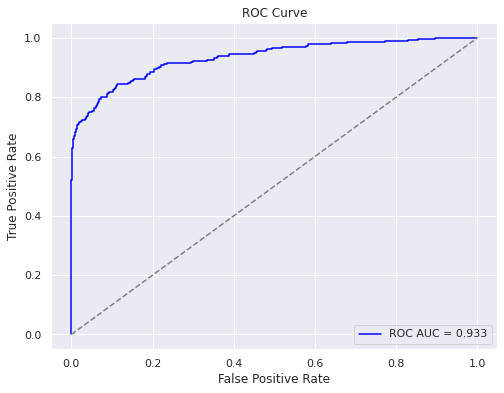

In [61]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.3f}', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

- Модель умеет выявлять значительную часть "ушедших" клиентов, почти не ошибаясь на "оставшихся".

Теперь построим матрицу ошибок, чтобы понять, сколько правильных и неправильных предсказаний для каждого класса

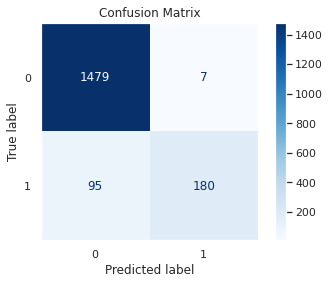

In [62]:
y_pred = catboost_search.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

- Слишком большой False Negative(33%) - модель ошибочно предсказала, что 93 клиента останутся, хотя на самом деле они ушли
- Остальные параметры отличные


### SHAP-анализ

Посмотрим, как каждый признак влияет на предсказание модели

In [63]:
best_model = catboost_search.best_estimator_
explainer = shap.TreeExplainer(best_model)

shap_values = explainer.shap_values(X_train)

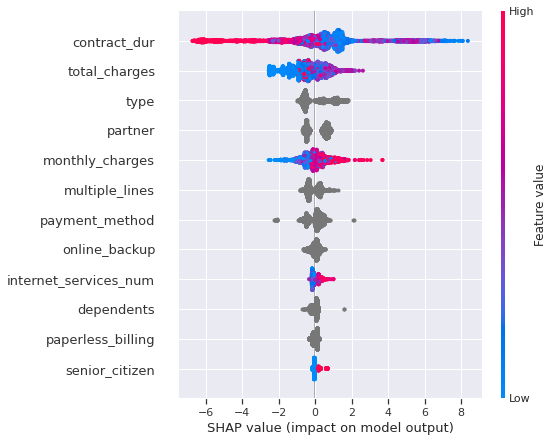

In [64]:
shap.summary_plot(shap_values, X_train, feature_names=X_train.columns)

**Какие выводы можно сделать из этого графика:**

- Чем дольше контракт, тем ниже вероятность оттока
- Клиенты, которые в сумме заплатили много, более склонны к оттоку
- Чем выше ежемесячная плата, тем выше вероятность оттока
- Чем больше интернет-услуг у клиента, тем выше вероятность оттока

**В результате анализа лучшей модели:**

- Модели не хватает точности в предсказании оттока(если заказчику важнее определить уход клиента, чем если он останется, тогда можно изменить порог классификации)
- Модель хорошо справляется с предсказанием клиентов, которые остаются
- Длительность контракта и общая сумма затрат клиента больше всего влияют на его отток

## Итоговый вывод

**В ходе проекта была решена задача классификации клиентов оператора связи по признаку оттока.**

- Был произведён первичный анализ 4 таблиц: информация о договоре, персональные данные клиента, информация об интернет-услугах, информация об услугах телефонии.
- Произведён исследовательский анализ таблиц:


    - **Информация о договоре**:
    1. Исправлена ошибка в типе данных столбца total_charges
    2. Добавлен целевой признак churn на основе информации из end_date
    3. Добавлен новый признак contract_dur, отвечающий за продолжительность контракта(вместо end_date и begin_date)
    4. Проведён анализ распределения данных (замечен дисбаланс классов в таргете)
    5. Проведён корреляционный анализ (все признаки были оставлены)

 
    - **Информация об интернет-услугах**:
    1. Произведена проверка данных на наличие дубликатов(их не оказалось)
    2. Добавлен признак *internet_services_num* - количество интернет-услуг
    3. 78% клиентов пользуются интернет-услугами
    4. Проведён анализ распределения данных

    - **Персональные данные клиента и информация об услугах телефонии**:
    1. Произведён исследовательский анализ


- Были объединены все 4 таблицы:
    1. Cоздана новая таблица  **telecom_data**
    2. В новой таблице пропущенные значения были заменены на "Not stated"

- Проведён исследовательский анализ объединённого датасета:
    1. Представлена тепловая карта датасета
    2. Найдены новые зависимости переменных
    3. Изучены соответсвия между новыми признаками и таргетом
    4. Создана новая таблица *telecom_data2*, в которой устранены проблемы мультиколлинеарности и которая содержит только значимые признаки
       
- Произведена подготовка данных:
    1. Данные были разделены на тренировочную и тестовую выборки
    2. Создан пайплайн, который будет кодировать данные перед подачей моде

- Было обучено три модели машинного обучения: LogisticRegression, CatBoostClassifier, Ensemble(RF, GB, LGB)
  
- Выбрана лучшая модель:
    1. Её параметры: CatboostClassifier('depth': 2, 'l2_leaf_reg': 3, 'learning_rate': 0.5, 'n_estimators': 500)
    2. Её точность на тестовых данных составила 0.94

- Произведён анализ лучшей модели:
    1. Модели не хватает точности в предсказании оттока(если заказчику важнее определить уход клиента, чем если он останется, тогда можно изменить порог классификации)
    2. Модель хорошо справляется с предсказанием клиентов, которые остаются
    3. Длительность контракта и общая сумма затрат клиента больше всего влияют на его отток

Модель способна заранее предсказывать вероятность ухода клиента, что может быть использовано для таргетированной маркетинговой активности: предложения промокодов, скидок, специальных условий для удержания.

Таким образом, разработанное решение поможет компании «ТелеДом» снизить уровень оттока, повысить удовлетворённость клиентов и оптимизировать бизнес-процессы по удержанию.

